**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2024</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2024 23:59 (GMT+3)</center></h4>

## **CIFAR-10 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 32x32 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [İpek Öztaş](mailto:ipek.oztas@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import gdown

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-10 dataset is downloadable from [this link](https://drive.google.com/file/d/1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW/view?usp=sharing). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
!gdown --id 1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW

!unzip -oq cifar10_dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW
From (redirected): https://drive.google.com/uc?id=1KSKSWiBKvfxBpWmDmuRvUkn77YvWaIFW&confirm=t&uuid=565accab-acc9-47a8-b519-51f1eba14ea9
To: /content/cifar10_dataset.zip
100% 142M/142M [00:00<00:00, 145MB/s]


### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-10 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
          ])
        self.labels = []
        self.class_indexes = {}

        self.prepare_dataset()

    def prepare_dataset(self):
        # listing all class subdirectories
        class_dirs = [entry.name for entry in os.scandir(self.root_dir) if entry.is_dir()]
        class_dirs.sort()
        self.class_indexes = {class_name: idx for idx, class_name in enumerate(class_dirs)}

        # traversing each class directory to collect image file paths
        for class_name in class_dirs:
            class_path = os.path.join(self.root_dir, class_name)

            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(class_path, file_name)
                    self.image_paths.append(full_path)
                    self.labels.append(self.class_indexes[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, id):
        img_path = self.image_paths[id]
        label = self.labels[id]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
train_path = '/content/train'
test_path = '/content/test'

train_dataset = CifarDataset(root_dir=train_path)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset(root_dir=test_path)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-10 images properly.

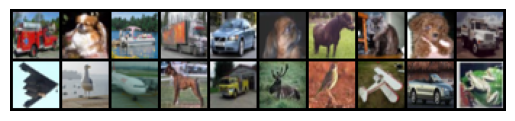

In [8]:
# Uncomment the cell when the dataloader is ready

images, labels = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [9]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # 32x32 to 16x16
        self.enc_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )

        # 16x16 to 8x8
        self.enc_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )

        # 8x8 to 4x4
        self.enc_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2)
        )

        # Decoder
        # 4x4 -> 8x8
        self.dec_layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        # 8x8 -> 16x16
        self.dec_layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2)
        )

        # 16x16 -> 32x32
        self.dec_layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=3,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # encoders
        x = self.enc_layer1(x)
        x = self.enc_layer2(x)
        x = self.enc_layer3(x)

        # decoders
        x = self.dec_layer1(x)
        x = self.dec_layer2(x)
        x = self.dec_layer3(x)

        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [10]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    model.train()
    losses = []  # store losses


    for epoch in range(num_epochs):
        cumulative_loss = 0.0  # tracking loss for each epoch

        for batch in train_dataloader:
            inputs, _ = batch
            ground = inputs.clone()

            # masking the half of the image
            inputs[:, :, :, 16:32] = -1

            # resetting gradient
            optimizer.zero_grad()

            # pass the masked inputs through the model
            predictions = model(inputs)

            # calculating loss
            loss = loss_func(predictions, ground)

            # backward propagation
            loss.backward()

            #updating weights
            optimizer.step()

            # add loss to cumulative
            cumulative_loss += loss.item()

        # analyzing the parameters
        average_epoch_loss = cumulative_loss / len(train_dataloader)
        losses.append(average_epoch_loss)
        print(f'For epoch [{epoch + 1}/{num_epochs}], loss is {average_epoch_loss:.4f}')

    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [11]:
def evaluate_model(model, test_dataloader):
    model.eval()  # set model to evaluate
    cumulative_mse = 0.0  # total MSE loss
    num_of_samples = 0  # num of samples

    # disabling gradient calculation for faster calculation
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, _ = batch
            target_images = inputs.clone()  # clone inputs to serve as the target

            # forward propagation through the model
            predictions = model(inputs)

            # computing MSE loss
            mse = torch.nn.functional.mse_loss(predictions, target_images, reduction='sum')
            cumulative_mse += mse.item()
            num_of_samples += inputs.size(0)

    #average MSE for all samples
    average_mse = cumulative_mse / num_of_samples
    return average_mse

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [12]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    batch = next(iter(dataloader))  # Taking one batch from the dataloader
    images, label = batch

    # Move the model to the same device as the input data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        masked_images = images.clone()
        masked_images[:, :, :, 16:] = -1
        masked_images = masked_images.to(device)  # Move masked images to the same device as the model
        inpainted_images = model(masked_images).cpu()

    # Normalize the images for display
    images = (images + 1) / 2
    masked_images = (masked_images.cpu() + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2

    # Concatenate and display images
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



For epoch [1/50], loss is 0.1442
For epoch [2/50], loss is 0.1145
For epoch [3/50], loss is 0.1103
For epoch [4/50], loss is 0.1081
For epoch [5/50], loss is 0.1067
For epoch [6/50], loss is 0.1057
For epoch [7/50], loss is 0.1050
For epoch [8/50], loss is 0.1044
For epoch [9/50], loss is 0.1039
For epoch [10/50], loss is 0.1036
For epoch [11/50], loss is 0.1031
For epoch [12/50], loss is 0.1028
For epoch [13/50], loss is 0.1025
For epoch [14/50], loss is 0.1023
For epoch [15/50], loss is 0.1021
For epoch [16/50], loss is 0.1018
For epoch [17/50], loss is 0.1016
For epoch [18/50], loss is 0.1015
For epoch [19/50], loss is 0.1013
For epoch [20/50], loss is 0.1012
For epoch [21/50], loss is 0.1010
For epoch [22/50], loss is 0.1009
For epoch [23/50], loss is 0.1008
For epoch [24/50], loss is 0.1007
For epoch [25/50], loss is 0.1005
For epoch [26/50], loss is 0.1005
For epoch [27/50], loss is 0.1003
For epoch [28/50], loss is 0.1003
For epoch [29/50], loss is 0.1002
For epoch [30/50], loss

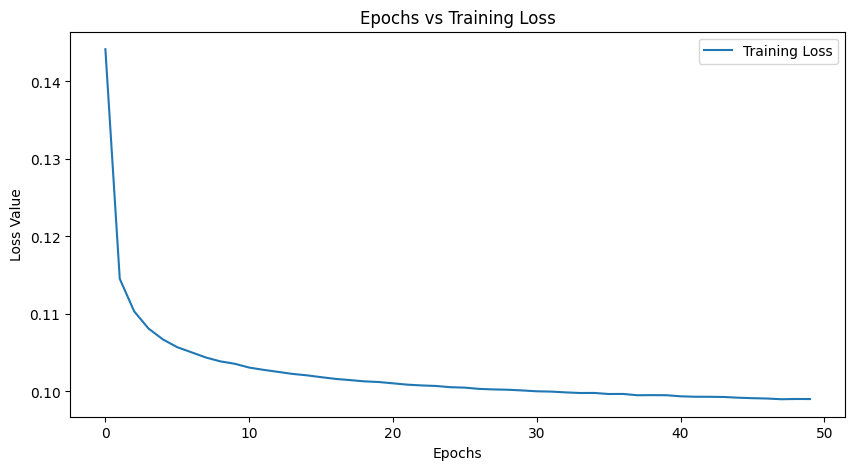

Average MSE for Test Data: 228.9099


In [16]:
seed_everything(464)
model = CifarAutoencoder() ## Uncomment when the model is implemented

# defining loss function and optimizer
mse_loss = torch.nn.MSELoss()  # mse loss
lr = 2e-4  # learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 50

# training the model and storing loss
training_losses = train_model(model, train_dataloader, optimizer, mse_loss, epochs)

# plotting the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')  # line plot for loss history
plt.title('Epochs vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

plt.legend()
plt.show()

# evaluate the model on the test dataset
average_mse = evaluate_model(model, test_dataloader)
print(f'Average MSE for Test Data: {average_mse:.4f}')

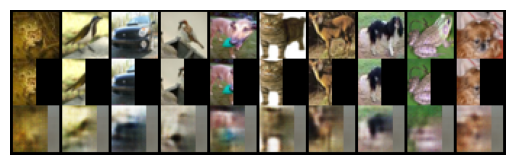

In [15]:
visualize_inpainting(model, test_dataset) ## Uncomment when the model is trained